# **Random Forest to Detect Unknown Attacks**

In [1]:
# basic data manipulation modules
import pandas as pd  
import numpy as np  

# metrics
from sklearn import metrics
#confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report  

# Undersampling modules dependencies
from imblearn.under_sampling import RandomUnderSampler   

# preprocessing modules
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline  
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

#classifier
from sklearn.ensemble import RandomForestClassifier  

#data visualisation modules
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# Read data  
df = pd.read_csv('cleaned_data.csv') #loading data

In [3]:
df.Label.value_counts()

Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64

In [4]:
# create a new DataFrame with rows where 'Label' is 'Bot'
df_bot = df[df['Label'] == 'Bot'].copy()

# remove rows where 'Label' is 'Bot' from the original DataFrame
df = df[df['Label'] != 'Bot']

In [5]:
df_bot.drop(columns= ['Unnamed: 0'], inplace=True)
df_bot.replace([np.inf, - np.inf], np.nan, inplace = True)
df_bot.dropna(inplace=True)
df_bot.reset_index(drop=True)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,8080,6,16079,3,4,326,129.0,326,0,108.666667,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
1,8080,6,577,2,0,0,0.0,0,0,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
2,8080,6,10279,3,4,326,129.0,326,0,108.666667,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
3,8080,6,457,2,0,0,0.0,0,0,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
4,8080,6,10271,3,4,326,129.0,326,0,108.666667,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286186,0,0,9487,10,0,0,0.0,0,0,0.000000,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
286187,51395,6,1030059,4,2,0,0.0,0,0,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
286188,51397,6,1029998,4,2,0,0.0,0,0,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
286189,51396,6,1030017,4,2,0,0.0,0,0,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot


In [6]:
# converting multiclass labels to binary df
def binary_label(df):
    df.loc[df['Label'] != 'Benign', 'Label'] = 'Abnormal'
    return df

df = binary_label(df)
df.drop(columns= ['Unnamed: 0'], inplace=True) # dropping unnecessary columns
df.replace([np.inf, - np.inf], np.nan, inplace = True)
df.dropna(inplace=True)
df.reset_index(drop=True)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,21,6,21,1,1,0,0.0,0,0,0.0,...,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Abnormal
1,21,6,3,1,1,0,0.0,0,0,0.0,...,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Abnormal
2,21,6,3,1,1,0,0.0,0,0,0.0,...,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Abnormal
3,21,6,3,1,1,0,0.0,0,0,0.0,...,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Abnormal
4,21,6,2,1,1,0,0.0,0,0,0.0,...,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961692,53,17,61898,2,2,78,254.0,39,39,39.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
7961693,1500,6,86213373,2,0,0,0.0,0,0,0.0,...,20,0.0,0.0,0.0,0.0,86213373.0,0.0,86213373.0,86213373.0,Benign
7961694,53,17,642,1,1,39,67.0,39,39,39.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
7961695,53,17,78472,1,1,32,121.0,32,32,32.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [7]:
data = df.copy() #copying the dataframe

### **Data Resampling/Balancing**

In [8]:
# labelencoder_n = LabelEncoder()
# data.iloc[:, -1] = labelencoder_n.fit_transform(data.iloc[:, -1])
# data.Label.value_counts()
data["Label"] = data["Label"].replace("Abnormal", 1)
data["Label"] = data["Label"].replace("Benign", 0)


In [9]:
data.Label.value_counts()

0    6077145
1    1884552
Name: Label, dtype: int64

Label Encoder Encoded;
- Benign = 0
- Abnormal = 1

In [10]:
x = data.drop(['Label'], axis=1)
y = data['Label']

In [11]:
under = RandomUnderSampler(sampling_strategy=1.0, random_state=222)  
X, Y = under.fit_resample(x, y)


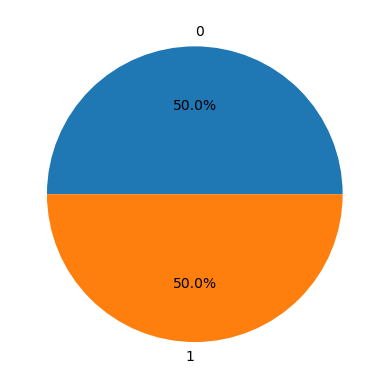

In [12]:
df = pd.concat([X, Y], axis=1)  
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')  # Plot a pie chart
plt.ylabel('')
plt.show()

In [13]:
df.shape

(3769104, 79)

### **Feature Selection**

In [14]:
fs = RandomForestClassifier()
fs.fit(X, Y)
importances = fs.feature_importances_
indices = np.argsort(importances)[::1]

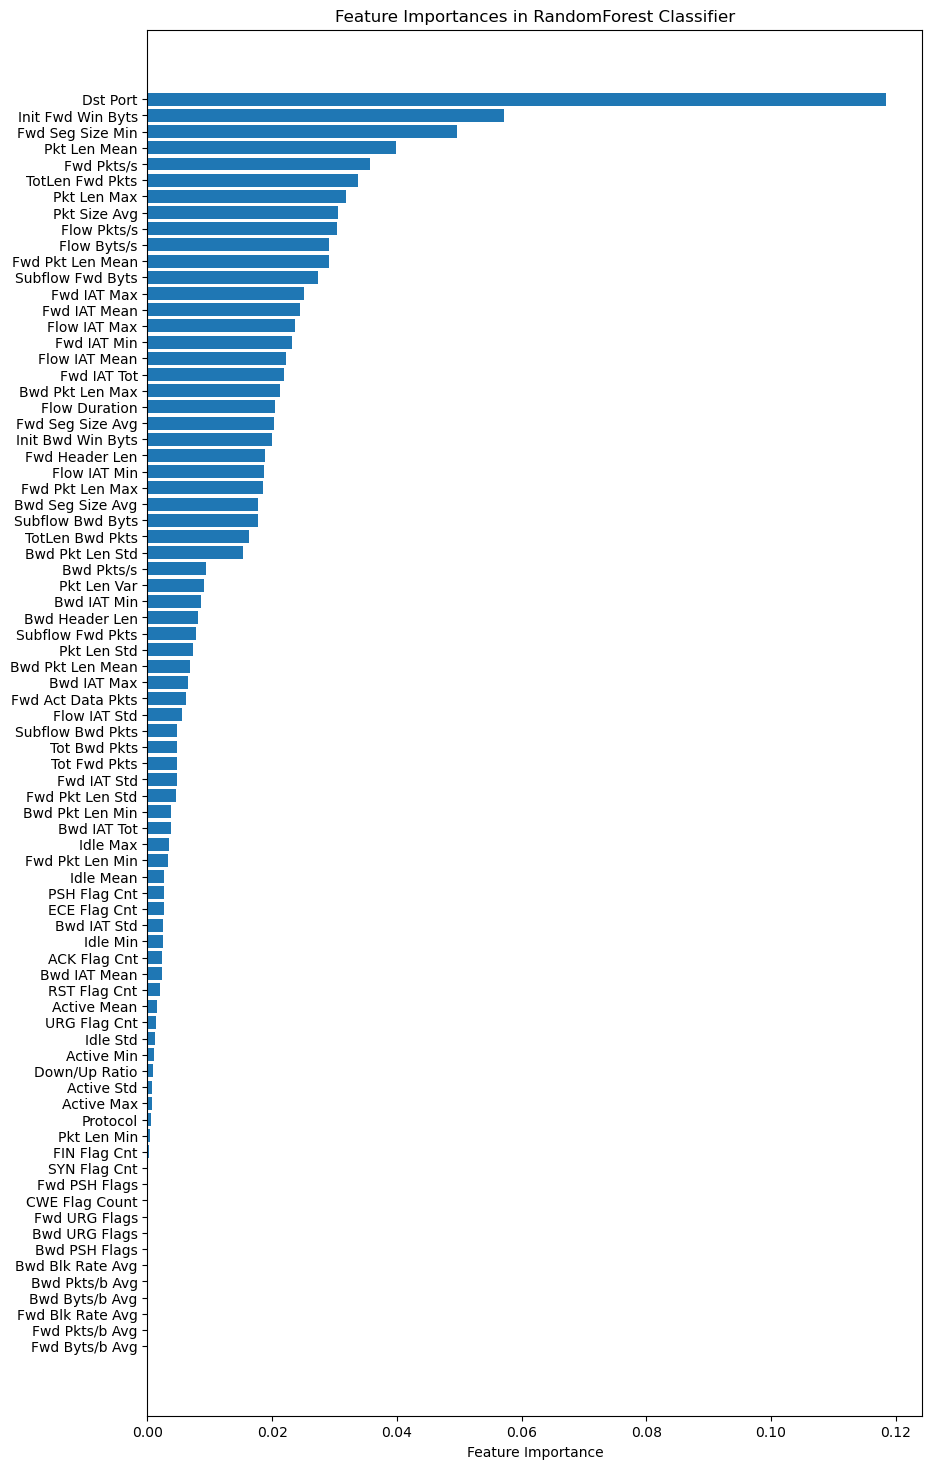

In [15]:
feature_names = X.columns
fig, ax = plt.subplots(figsize=(10, 18))
ax.barh(range(len(indices)), importances[indices], align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(feature_names[indices])
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importances in RandomForest Classifier')
plt.show()

In [16]:
# Select features with importance > mean importance
threshold = np.mean(importances)  # Normalize the threshold  
sfm = SelectFromModel(fs, threshold=threshold)  
sfm.fit(X, Y)  
selected_features = list(X.columns[sfm.get_support()])

In [17]:
# Create reduced DataFrame  
sel_df = df[selected_features + ['Label']]  
sel_df.columns

Index(['Dst Port', 'Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
       'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
       'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Fwd Seg Size Min', 'Label'],
      dtype='object')

#### **Spliting Data**

In [18]:
X = sel_df.drop(['Label'], axis=1)
y = sel_df['Label']


In [19]:
#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=123)

### **Helper Functions**

In [20]:
def plot_confusion_matrix(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # define class labels, based on encoding, Bening:0, Abnormal:1
    class_labels = ['Benign', 'Abnormal']
    # set x-axis label
    plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
    plt.xlabel('Predicted')
    #  y-axis labels
    plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
    plt.ylabel('True')
    plt.show()

In [21]:
def print_metrics(y_true, y_pred):
    print('Accuracy:', metrics.accuracy_score(y_true, y_pred))
    print('Precision:', metrics.precision_score(y_true, y_pred))
    print('Recall:', metrics.recall_score(y_true, y_pred))
    print('F1 Score:', metrics.f1_score(y_true, y_pred))


In [46]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


### **Modelling**
- Random Forest



In [23]:
rf_params = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

In [24]:
RF_best = RandomForestClassifier(**rf_params,random_state=123)
RF_best.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=123)

### **Testing RF Model Performance Overall**

In [25]:
y_pred_RF = RF_best.predict(X_test)

In [26]:
print_metrics(y_test, y_pred_RF)


Accuracy: 0.9602173460277705
Precision: 0.9843441711241903
Recall: 0.9352454946403014
F1 Score: 0.9591669174283693


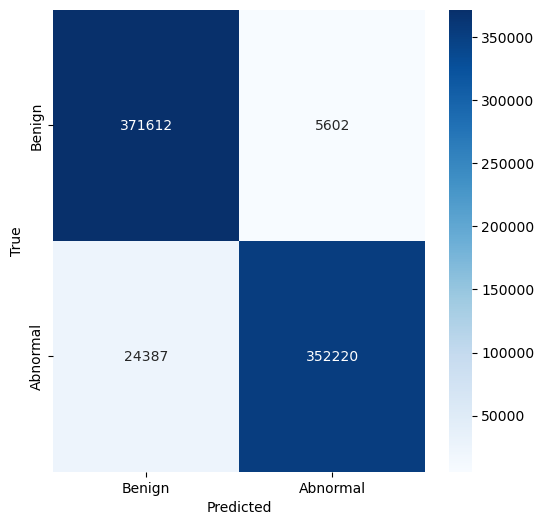

In [27]:
plot_confusion_matrix(y_test, y_pred_RF)

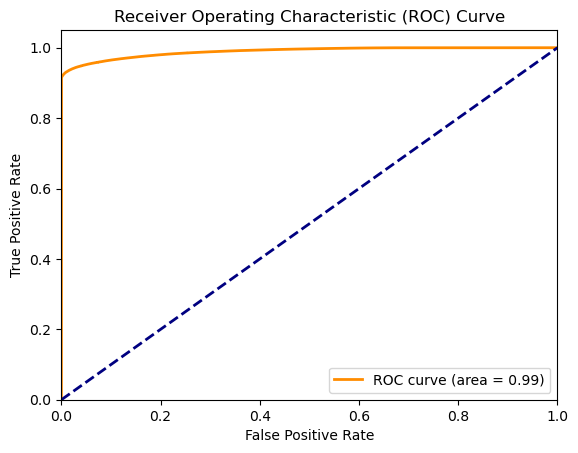

In [28]:
# get the predicted probabilities
y_prob_RF = RF_best.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_prob_RF)

# **Testing RF on Bot Attacks**

In [29]:
df_bot.Label.value_counts()

Bot    286191
Name: Label, dtype: int64

In [30]:
# Assuming your DataFrame is called "df"
df_bot["Label"] = df_bot["Label"].replace("Bot", 1) # 0 for attacks (Abnormal)

In [31]:
df_bot.Label.value_counts()

1    286191
Name: Label, dtype: int64

- Full Features

In [32]:
X_bot = df_bot.drop(['Label'], axis=1)
y_bot =  df_bot['Label']

In [33]:
y_pred_bot_RF = fs.predict(X_bot)

In [34]:
print_metrics(y_bot,y_pred_bot_RF)

Accuracy: 0.000974873423692569
Precision: 1.0
Recall: 0.000974873423692569
F1 Score: 0.0019478479421929


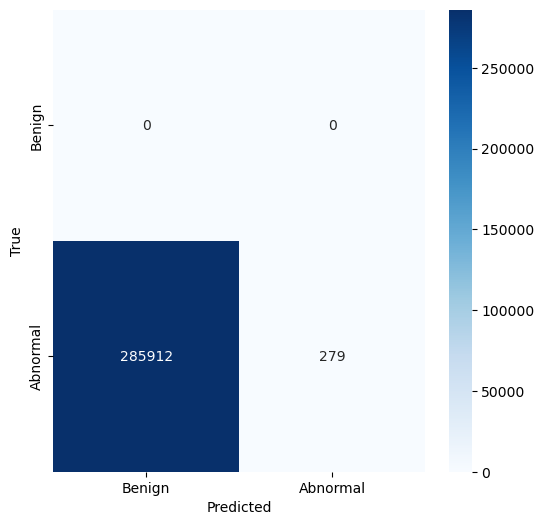

In [35]:
plot_confusion_matrix(y_bot, y_pred_bot_RF)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


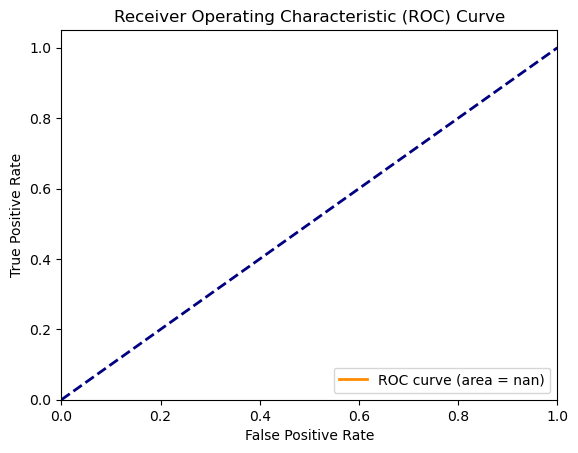

In [36]:
# get the predicted probabilities
y_prob_bot_RF = fs.predict_proba(X_bot)[:, 1]
plot_roc_curve(y_bot, y_prob_bot_RF)

- Reduced Features

In [37]:
sel_df_bot = df_bot[selected_features + ['Label']]  
sel_df_bot.columns

Index(['Dst Port', 'Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
       'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
       'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Fwd Seg Size Min', 'Label'],
      dtype='object')

In [38]:
X_bot = sel_df_bot.drop(['Label'], axis=1)
y_bot =  sel_df_bot['Label']

In [39]:
y_pred_bot_RF_sel = RF_best.predict(X_bot)

In [40]:
print_metrics(y_bot,y_pred_bot_RF_sel)


Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


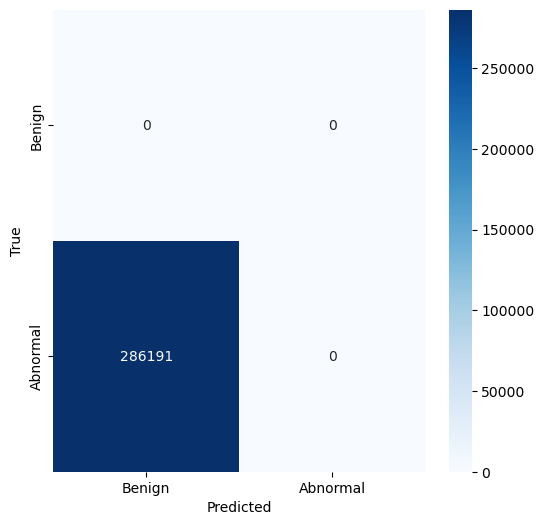

In [41]:
plot_confusion_matrix(y_bot, y_pred_bot_RF_sel)

Rf unable to identify the Abnormal Bot Traffice, as it misclassified it all into Benign class.